## Quiz 2

1. Generate a sample of 200 points from a 2D Gaussian with mean $\mu_1 = \begin{bmatrix} 3 \\ 3 \end{bmatrix}$ and covariance $\Sigma_1 = \begin{bmatrix} 4 & 0 \\ 0 & 4 \end{bmatrix}$ (1 point)

Hint: np.random.multivariate_normal()

In [9]:
import numpy as np
mean = np.array([3, 3])
cov = np.array([[4, 0],[0, 4]])
data1 = np.random.multivariate_normal(mean, cov, 200).T

2. Generate a second sample of 200 points from a 2D Gaussian with mean $\mu_2 = \begin{bmatrix} 5 \\ 5 \end{bmatrix}$ and covariance $\Sigma_2 = \begin{bmatrix} 4  &  0 \\ 0 & 4 \end{bmatrix}$. (1 point)


In [10]:
mean = np.array([5, 5])
cov = np.array([[4, 0],[0, 4]])
data2 = np.random.multivariate_normal(mean, cov, 200).T

3. Assuming the first set of points is class 0 and the second set of points is class 1, plot the data with different colors for each class below.


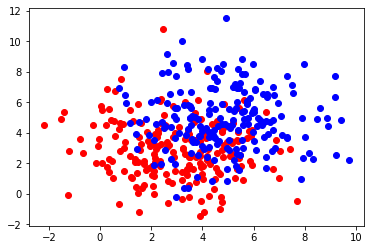

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(data1[0], data1[1], color='red')
ax.scatter(data2[0], data2[1], color='blue')

plt.show()

4. StandardScale your data and Split to training, validation and testing sets with the ratio of 70:10:20. You may use train_test_split from sklearn or from-scratch. Any of your choosing will do. (2 points)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

y1 = np.zeros((200))
y2 = np.ones((200))

X = np.concatenate((data1, data2), axis=1).T
y = np.concatenate((y1, y2))

XX = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)

X_transform = scaler.fit_transform(XX)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_transform, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(10/80))

5. Perform a classification using logistic regression using LogisticRegression class you have written (hopefully you submitted the assignments). This should be **stochastically** trained. Make sure to plot your training loss during the training. (2 points)

In [42]:
# Class Logistic Regression
class LogisticRegression:
    def __init__(self, method="minibatch", l_rate=0.01, 
                    batch_percent=10, max_iter=1000):
        self.method = method
        self.l_rate = l_rate
        self.batch_percent = batch_percent
        self.max_iter = max_iter

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        batch_size = int(self.batch_percent/100 * X.shape[0])
        self.loss = []
        list_of_used_ix = []     
        for i in range(self.max_iter):
            if self.method == "minibatch":
                idx = np.random.randint(0, X.shape[0])
                batch_X = X[idx:idx+batch_size]
                batch_y = y[idx:idx+batch_size]
            elif self.method == "sto":
                idx = np.random.randint(0, X.shape[0])
                while idx in list_of_used_ix:
                    idx = np.random.randint(X_train.shape[0])
                batch_X = X[idx, :].reshape(1, -1)
                batch_y = y[idx]
                list_of_used_ix.append(idx)
                if len(list_of_used_ix) == X_train.shape[0]: list_of_used_ix = []
            elif self.method == "batch":
                batch_X = X
                batch_y = y
            else:
                print("Method is not match")
            cost, grad = self.gradient(batch_X, batch_y)
            self.loss.append(cost)
            self.w = self.w - self.l_rate * grad
        self.iter = i+1

    def sigmoid(self, x):        
        return 1 / (1 + np.exp(-x))

    def gradient(self, X, y):
        h = self.h_theta(X, self.w)
        error = h - y
        # putting negative sign for negative log likelihood
        cost = - np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        grad = np.dot(X.T, error)
        return cost, grad

    def h_theta(self, X, w):
        return self.sigmoid(X @ w)

    def plot_loss(self):
        x_axis = [*range(self.iter)]
        y_axis = self.loss
        plt.plot(x_axis, y_axis)
        plt.title("Losses - iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Losses")

    def y_predict(self, X):
        return np.round(self.h_theta(X, self.w))




In [69]:
model = LogisticRegression(method="sto", l_rate=0.001, max_iter=10000)
model.fit(X_train, y_train)
yhat = model.y_predict(X_val)

<function matplotlib.pyplot.show(close=None, block=None)>

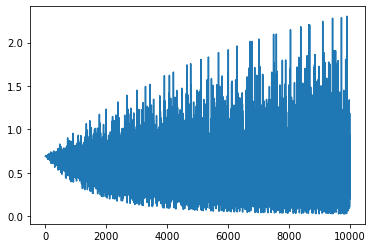

In [56]:
plt.plot(list(range(model.iter)), model.loss)
plt.show

6. Evalutate your model using your **from-scratch classification reports**. (1 point)

In [70]:
TP = sum((y_val == 1) & (yhat == 1))
FN = sum((y_val == 1) & (yhat == 0))
FP = sum((y_val == 0) & (yhat == 1))
TN = sum((y_val == 0) & (yhat == 0))

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
f1 = (2 * precision * recall)/(precision + recall)

print("accuracy:",accuracy)
print("precision:",precision)
print("recall:",recall)
print("f1:", f1)

accuracy: 0.85
precision: 0.75
recall: 0.8571428571428571
f1: 0.7999999999999999


7. Now, perform GNB using sklearn and use **classification_reports from sklearn** to evaluate your model. (1 point)

In [105]:
class GaussianNaive:
    def fit(self, X, y):
        n = X.shape[1]
        self.k =len(np.unique(y))
        self.mean = np.zeros((self.k, n))
        self.std = np.zeros((self.k, n))
        m = np.zeros(self.k)
        for label in range(self.k):
            self.mean[label, :] = X[y==label].mean(axis=0)
            self.std[label, :]  = X[y==label].std(axis=0)
            m[label] = len(X[y==label])
        self.prior = m/sum(m)

    def gaussian_pdf(self, X, mean, std):
        left = 1 / (np.sqrt(2 * np.pi) * std)
        e = (X - mean) ** 2 / (2 * (std ** 2))
        right = np.exp(-e)
        return left*right

    def predict(self, X):
        posterior = np.zeros((X.shape[0], self.k))
        for label in range(self.k):
            likelihood = self.gaussian_pdf(X, self.mean[label,:], self.std[label,:])
            total_likelihood = np.prod(likelihood, axis=1)
            posterior[:,label] = self.prior[label]*total_likelihood
        yhat = np.argmax(posterior, axis=1)
        return yhat


In [106]:
print(X_train[:,1:].shape)
model2 = GaussianNaive()
model2.fit(X_train[:,1:], y_train)
yhat = model2.predict(X_val[:,1:])


TP = sum((y_val == 1) & (yhat == 1))
FN = sum((y_val == 1) & (yhat == 0))
FP = sum((y_val == 0) & (yhat == 1))
TN = sum((y_val == 0) & (yhat == 0))

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
f1 = (2 * precision * recall)/(precision + recall)

print("accuracy:",accuracy)
print("precision:",precision)
print("recall:",recall)
print("f1:", f1)

(280, 2)
accuracy: 0.8
precision: 0.6666666666666666
recall: 0.8571428571428571
f1: 0.75


8. In Q4, you were asked to set aside some data as your validation set. Notice that we have not used it at all. If we were to use it, how would you go about this? (1 point)

* We can use the validation set in case that we want to find the best hyperparameter of model. If we try to train the model by using a set of hyperparameter, we can test which value is the best by test the validation set and calculate the accuracy.

9. **Discuss** your results (DISCUSS NOT REPORT). (2 points)

Examples: which one is better, why? and why not?. The nature of data? which model is more suitable? How to improve your results? 

In [16]:
# Your DISCUSSION here